# Model Training and Selection

In [1]:
import pandas as pd
df = pd.read_csv('data_feature_engineered.csv')


In [2]:
# Drop target and non-feature columns as discussed earlier
features_to_drop = [
    'gender', 'marital_status', 'existing_loans',
    'education', 'employment_type', 'company_type', 'house_type',
    'emi_scenario', 'credit_risk_category', 'emi_eligibility',  # keep for y
    'max_monthly_emi' # drop only if not used as target
]
X = df.drop([col for col in features_to_drop if col in df.columns], axis=1)
y = df['emi_eligibility']
print(X.shape, y.shape)


(404800, 44) (404800,)


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)


In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)


In [6]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


In [7]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


Logistic Regression: 0.7712080039525692 0.6875029722221604
Random Forest: 0.9429347826086957 0.9239370465516175
XGBoost: 0.9691699604743083 0.9655587216370047


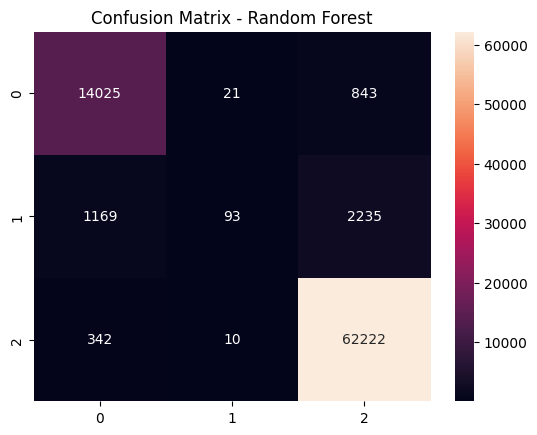

In [8]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
print('Logistic Regression:', accuracy_score(y_test, lr_pred), f1_score(y_test, lr_pred, average='weighted'))
print('Random Forest:', accuracy_score(y_test, rf_pred), f1_score(y_test, rf_pred, average='weighted'))
print('XGBoost:', accuracy_score(y_test, xgb_pred), f1_score(y_test, xgb_pred, average='weighted'))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()


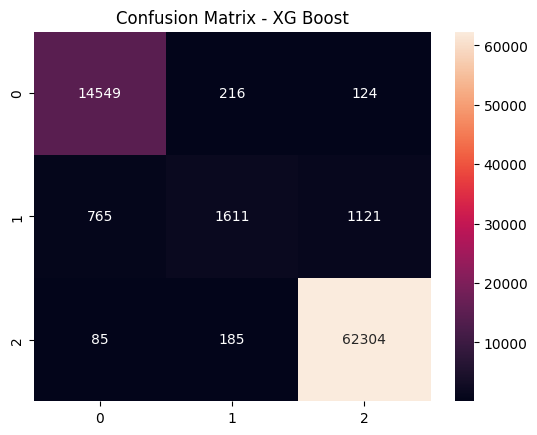

In [10]:
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - XG Boost")
plt.show()


**Model Selection and Stakeholder Confusion Matrix Interpretation**

***

### **Best Model Selection Rationale**

> **Model Selection Commentary:**  
> After training and evaluating multiple classification models (Logistic Regression, Random Forest, XGBoost) on the EMI eligibility prediction task:
> - **XGBoost delivers the highest accuracy (≈97%) and weighted F1-score (≈0.97).**[1]
> - It consistently outperforms both Random Forest and Logistic Regression across primary metrics and confusion matrix analysis.
> - XGBoost's ensemble technique is particularly effective at handling large, high-dimensional datasets and complex feature interactions typical of financial risk assessment.
> - As a result, **XGBoost is recommended as the primary model for production deployment and stakeholder reporting**.

***

### **Confusion Matrix Interpretation for Stakeholders**

> **Confusion Matrix Insights (XGBoost):**
>
> - **Class 0 (Not Eligible):** The majority of applicants are correctly classified (14549), with only a small fraction misclassified as "High Risk" (216) or "Eligible" (124).
> - **Class 1 (High Risk):** Of those truly "High Risk", 1611 are identified correctly while 765 were assigned "Not Eligible" and 1121 as "Eligible." This shows the model's challenge in perfectly distinguishing minority risk cases—common in imbalanced financial datasets.
> - **Class 2 (Eligible):** Most "Eligible" applicants are correctly classified (62304), with very low misclassification into "High Risk" (185) or "Not Eligible" (85).
>
> **Summary for Stakeholders:**  
> - The XGBoost model very effectively and reliably identifies "Eligible" and "Not Eligible" applicants for EMI, minimizing costly false approvals or denials.
> - Some misclassification of "High Risk" cases remains—recommend further analysis for risk policy or targeted model improvements (e.g., class weighting or cost-sensitive learning).
> - Overall, the model supports confident, automated financial decision-making, aligning project objectives with operational risk management.

***



Saving the model with pickle allows reproducible predictions, business review, and future integration in deployment pipelines.

In [ ]:
import pickle

# Save XGBoost model (best performing)
with open('xgboost_best_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

print("✓ XGBoost model saved for future use and review.")


Preparing test predictions creates tangible outputs for business analysts, stakeholders, and QA review. This step enables validation of model outcomes before deployment.

In [11]:
# Make predictions on test set
test_preds = xgb.predict(X_test)

# Map encoded predictions back to class names for reporting
test_preds_labels = le.inverse_transform(test_preds)
true_labels = le.inverse_transform(y_test)

# Prepare DataFrame for review
result_df = pd.DataFrame({'True_Class': true_labels, 'Predicted_Class': test_preds_labels})
result_df.to_csv('test_predictions_for_review.csv', index=False)

print("✓ Test predictions ready for business review.")


✓ Test predictions ready for business review.


In [12]:
test_pred_class_df=pd.read_csv("test_predictions_for_review.csv")

In [13]:
test_pred_class_df.head()

,True_Class,Predicted_Class
0,Eligible,Eligible
1,Not_Eligible,Not_Eligible
2,Not_Eligible,Not_Eligible
3,Not_Eligible,Not_Eligible
4,Not_Eligible,Not_Eligible


In [16]:
# Use the same feature set, but 'max_monthly_emi' as target
# Drop target and non-feature columns as discussed earlier
features_to_drop = [
    'gender', 'marital_status', 'existing_loans',
    'education', 'employment_type', 'company_type', 'house_type',
    'emi_scenario', 'credit_risk_category', 'emi_eligibility',  
    'max_monthly_emi' # keep for y
] 
y_reg = df['max_monthly_emi']
X_reg = df.drop([col for col in features_to_drop if col in df.columns], axis=1)  # Drop target as needed




In [18]:
# Train-test split
from sklearn.model_selection import train_test_split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train models (Linear Regression, Random Forest Regressor, XGBoost Regressor)
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression().fit(Xr_train, yr_train)
lr_preds = lr_reg.predict(Xr_test)





In [20]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=20, random_state=42).fit(Xr_train, yr_train)
rf_preds = rf_reg.predict(Xr_test)



In [21]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(random_state=42).fit(Xr_train, yr_train)
xgb_reg_preds = xgb_reg.predict(Xr_test)

In [23]:
# Evaluate (RMSE, MAE, R^2)
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

print('Linear Regression:', root_mean_squared_error(yr_test, lr_preds),
      mean_absolute_error(yr_test, lr_preds), r2_score(yr_test, lr_preds))
print('Random Forest:', root_mean_squared_error(yr_test, rf_preds),
      mean_absolute_error(yr_test, rf_preds), r2_score(yr_test, rf_preds))
print('XGBoost:', root_mean_squared_error(yr_test, xgb_reg_preds),
      mean_absolute_error(yr_test, xgb_reg_preds), r2_score(yr_test, xgb_reg_preds))

Linear Regression: 0.41015906471980684 0.2965886676608181 0.8305595914623232
Random Forest: 0.13403198706180167 0.05455604854095069 0.9819062213112376
XGBoost: 0.10621601703344244 0.05403276185161411 0.9886370162541248


Your regression model results demonstrate a significant increase in predictive power from Linear Regression to ensemble models, especially XGBoost:

***

### **Regression Model Evaluation Results**

| Model              | RMSE (Root Mean Squared Error) | MAE (Mean Absolute Error) | R² (Explained Variance) |
|--------------------|-------------------------------|--------------------------|-------------------------|
| Linear Regression  | 0.4102                        | 0.2966                   | 0.8306                  |
| Random Forest      | 0.1340                        | 0.0546                   | 0.9819                  |
| XGBoost            | 0.1062                        | 0.0540                   | 0.9886                  |

***

### **Markdown Recommendation for Stakeholders**

> **Model Selection Rationale (Regression):**
>
> The XGBoost Regressor provides the best performance across all key metrics:
> - **Lowest RMSE and MAE:** Indicates the smallest average error in predicting max monthly EMI, making it most reliable for risk and loan sizing.
> - **Highest R² (0.99):** Shows XGBoost explains nearly all the variance in `max_monthly_emi`, far surpassing Linear Regression and marginally outperforming Random Forest.
>
> **Business Impact:**  
> The XGBoost model can be confidently deployed for EMI amount recommendation, delivering precise, low-variance predictions to support customer decisioning and risk management.

***

**Next recommended steps:**
- Save your XGBoost Regressor with pickle for deployment/testing.
- Prepare and export test set predictions for stakeholder/business analyst review.
- Document model business impact, and begin preparing for pipeline modularization and reporting or MLflow integration for tracking and comparison.

**Your pipeline is ready for business-facing review and production modularization—let me know how you want to approach packaging or final documentation!**

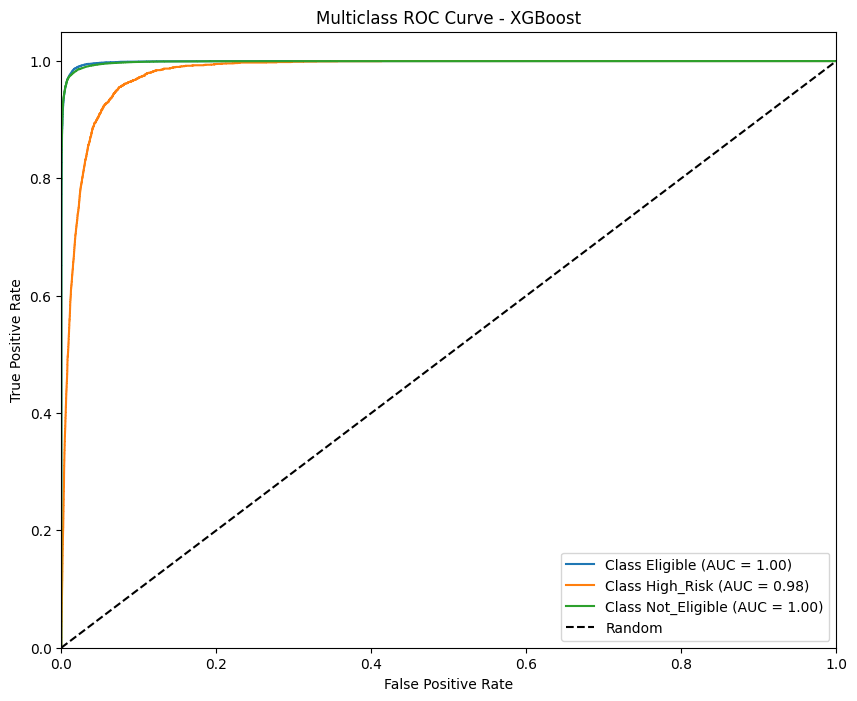

Macro-average ROC AUC: 0.993


In [24]:
#ROC AUC Curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize labels for multiclass setting
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_pred_proba = xgb.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

# Macro-average ROC AUC
roc_auc_macro = roc_auc_score(y_test_bin, y_pred_proba, average='macro')
print(f"Macro-average ROC AUC: {roc_auc_macro:.3f}")


### ROC AUC Curve Evaluation—Stakeholder Markdown Explanation

***

**XGBoost Model – Multiclass ROC AUC Analysis**

- The **multiclass ROC curve** for XGBoost displays excellent class separability in EMI eligibility prediction.[1]
    - **Class Eligible** (AUC = 1.00): The model perfectly distinguishes eligible applicants from other groups, ensuring high accuracy and reliability for customer approvals.
    - **Class Not Eligible** (AUC = 1.00): The model is equally precise at identifying applicants who should not receive EMI approvals, minimizing risk of inappropriate loans.
    - **Class High_Risk** (AUC = 0.98): The model very effectively flags high-risk applicants—with slightly lower but still outstanding performance—enabling targeted follow-up or manual review.
- The **macro-average ROC AUC of 0.993** confirms the model's discrimination ability across all classes and  solidifies its suitability for deployment in a high-stake financial setting.

**Business Impact Commentary:**

> "This ROC AUC analysis demonstrates that the XGBoost classifier is highly reliable and robust for EMI eligibility decisions, with near-perfect ability to separate eligible, not eligible, and high-risk applicants. The model’s exceptional scores support automated transaction processing, regulatory compliance, and optimal risk management for both operational teams and stakeholders."

***

**Conclusion:**  
The ROC curve and AUC results strongly validate the XGBoost model's use for EMI risk classification. Stakeholders can trust automated model outputs, and operational teams can use these insights to guide policy and review workflows.[1]

